The initial model created within AlphabetSoupCharity.ipynb reached an accuracy of 72%. The model will be reran and optimised within this file.  

## <b>Preprocessing</b>

In [1]:
!pip install autokeras

# Imports the required dependencies
from sklearn.model_selection import train_test_split         # Enables the splitting of the input data into training and test datasets
from sklearn.preprocessing import StandardScaler             # Enables the scaling of the training and test data sets to minimise the risks associated with raw numerical data e.g. outlier impact, different units, skewed distribution
import pandas as pd                                          # Enables the ability to work with DataFrames
import tensorflow as tf                                      # Enables the deploymentof machine learning models
from tensorflow.keras.callbacks import ModelCheckpoint       # Enables interval saving of the model's weights
import matplotlib.pyplot as plt                              # Enables visual plotting of data
import numpy as np                                           # Assists with computing quartiles within a given list
from google.colab import files                               # Enables files to be exported

Target variable:
- IS_SUCCESSFUL

Feature variables for model:
- APPLICATION_TYPE
- AFFILIATION
- CLASSIFICATION
- USE_CASE
- ORGANIZATION
- INCOME_AMT
- SPECIAL_CONSIDERATIONS
- ASK_AMT

In [2]:
# Imports and reads the charity_data.csv
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")

# Displays the first five rows within the newly created DataFrame
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Drops the non-beneficial ID columns, 'EIN' and 'NAME' as they won't provide the machine learning model with meaningful insights.
# In addition, the "STATUS" column will also be dropped to reduce the noise within the input features
application_df = application_df.drop(["EIN", "NAME", "STATUS"], 1)

# Displays the first five rows within the DataFrame to check that the non-beneficial columns have been dropped
application_df.head()

<ipython-input-3-b4c764d4ffcb>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  application_df = application_df.drop(["EIN", "NAME", "STATUS"], 1)


,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,100000-499999,N,142590,1


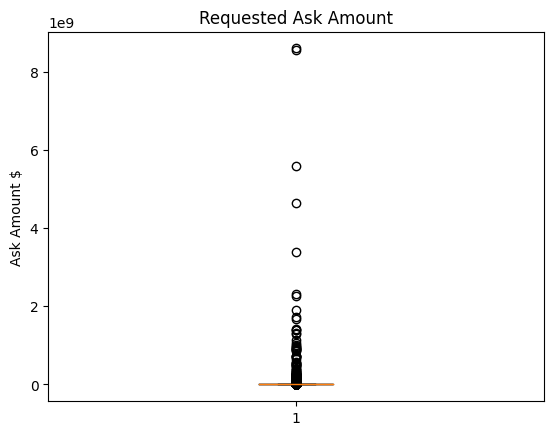

In [4]:
# Converts the ASK_AMT column within the application DataFrame into a list of values
ask_amounts = application_df["ASK_AMT"].tolist()

# Box plot created to help identify potential outliers for the ask amounts
fig1, ax1 = plt.subplots()
ax1.set_title('Requested Ask Amount')
ax1.set_ylabel('Ask Amount $')
ax1.boxplot(ask_amounts)
plt.show()

In [5]:
# Calculates the interquartile range of the ask amounts
quartiles = np.quantile(ask_amounts,[.25,.75])
iqr = quartiles[1]-quartiles[0]

# Determines the upper and lower bounds
lower_bound = quartiles[0]-(1.5*iqr)
upper_bound = quartiles[1]+(1.5*iqr)

# List comprehension to store potential outliers within the ask amounts
potential_outliers = [amount for amount in ask_amounts if amount < lower_bound or amount > upper_bound]

In [6]:
# Obtains a series which excludes all potential outliers that exist within the ASK_AMT column in the application DataFrame
not_outlier = application_df["ASK_AMT"].isin(potential_outliers) == False

# Only keeps rows in the application DataFrame which do not match with the potential outliers found within the AMT_ASK column
application_df = application_df[not_outlier]

In [7]:
# Determines the number of unique values in each column
# Any categorical variables which contain 10 or more unique values will apply the bucketing strategy to optimise memory resourcing
application_df.nunique()

APPLICATION_TYPE           12
AFFILIATION                 6
CLASSIFICATION             65
USE_CASE                    5
ORGANIZATION                4
INCOME_AMT                  9
SPECIAL_CONSIDERATIONS      2
ASK_AMT                   656
IS_SUCCESSFUL               2
dtype: int64

In [8]:
# The APPLICATION_TYPE column had > 10 unique values, therefore it's value counts will be observed to help inform on which binning approach to take
application_df["APPLICATION_TYPE"].value_counts()

T3     20086
T4      1331
T19      999
T5       894
T6       882
T8       669
T7       633
T10      508
T13       54
T9        18
T12       13
T2         6
Name: APPLICATION_TYPE, dtype: int64

In [9]:
# Any application type which represent less than 1% of the total number of applications will be binned into a category called 'Other'

# APPLICATION_TYPE value counts < 260 (1% of the total applications)
application_types_below_threshold = application_df["APPLICATION_TYPE"].value_counts() < 260

# A list of the application types to be replaced
application_types_to_replace = application_df['APPLICATION_TYPE'].value_counts()[application_types_below_threshold].index.tolist()

# Loops through each application type to be replaced and replaces it's value to "Other" within the application DataFrame.
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Reviews the value counts in the APPLICATION_TYPE column to verify that the requested application types are now binned together within the 'Other' category
application_df['APPLICATION_TYPE'].value_counts()

<ipython-input-9-a3704063a785>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")


T3       20086
T4        1331
T19        999
T5         894
T6         882
T8         669
T7         633
T10        508
Other       91
Name: APPLICATION_TYPE, dtype: int64

In [10]:
# The CLASSIFICATION column also had > 10 unique values, therefore it's value counts will be observed to help inform on which binning approach to take
application_df["CLASSIFICATION"].value_counts()

C1000    12557
C2000     4693
C1200     3997
C2100     1623
C3000     1537
         ...  
C1732        1
C1728        1
C4120        1
C1245        1
C2150        1
Name: CLASSIFICATION, Length: 65, dtype: int64

In [11]:
# CLASSIFICATION value counts > 1
classifications_above_one = application_df["CLASSIFICATION"].value_counts() > 1
application_df["CLASSIFICATION"].value_counts()[classifications_above_one ]

C1000    12557
C2000     4693
C1200     3997
C2100     1623
C3000     1537
C7000      546
C1700      223
C4000      129
C5000      106
C1270       89
C2700       75
C7100       62
C2800       61
C1280       46
C1300       42
C1230       35
C2300       28
C1240       28
C1400       27
C7200       20
C6000       14
C8000       13
C1250       13
C7120       11
C1278       10
C1237        9
C8200        9
C1238        9
C1235        9
C1500        7
C1720        6
C1257        5
C7210        5
C2400        4
C1600        4
C4100        4
C1260        3
C1800        3
C1267        2
C1246        2
C1256        2
C0           2
Name: CLASSIFICATION, dtype: int64

In [12]:
# Any classification which represents less than 3% of the total number of applications will be binned into a category called 'Other'

# CLASSIFICATION value counts < 782 (3% of the total applications)
classifications_below_threshold = application_df["CLASSIFICATION"].value_counts() < 782

# A list of the classifications to be replaced
classifications_to_replace = application_df['CLASSIFICATION'].value_counts()[classifications_below_threshold].index.tolist()

# Loops through each classification to be replaced and replaces it's value to "Other" within the application DataFrame.
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")

# Reviews the value counts in the CLASSIFICATION column to verify that the requested clasifications are now binned together within the 'Other' category
application_df['CLASSIFICATION'].value_counts()

C1000    12557
C2000     4693
C1200     3997
Other     1686
C2100     1623
C3000     1537
Name: CLASSIFICATION, dtype: int64

In [13]:
# A list of all the columns in the application DataFrame with an object data type
application_categories = application_df.dtypes[application_df.dtypes == "object"].index.tolist()

# Converts the categorical data to numerical values with `pd.get_dummies`
encode_df = pd.get_dummies(application_df[application_categories])

encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [14]:
# Merges the encoded features to the application DataFrame
application_df = application_df.merge(encode_df, left_index=True, right_index=True)

# Drops the original categories from the application DataFrame
application_df = application_df.drop(application_categories, 1)

# Displays the first five rows within the amended application DataFrame
application_df.head()

<ipython-input-14-c7a27cd05834>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  application_df = application_df.drop(application_categories, 1)


,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,5000,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,5000,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,6692,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
5,5000,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,5000,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [15]:
# Splits the preprocessed data into features and target arrays
y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop(["IS_SUCCESSFUL"], 1).values

# Splits the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

<ipython-input-15-32b9bd2fed4b>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = application_df.drop(["IS_SUCCESSFUL"], 1).values


In [16]:
# Creates a StandardScaler instance
scaler = StandardScaler()

# Fits the StandardScaler to the training features
X_scaler = scaler.fit(X_train)

# Scales the training and testing features
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## <b>Compile, Train and Evaluate the Model</b>

In [17]:
# Defines the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 11
hidden_nodes_layer2 = 28                                                                                     # Number of neurons in the second layer has been amended from the original model

# Creates model instance
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh")) # Activation function of first layer has been amended from the original model

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Checks the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                473       
                                                                 
 dense_1 (Dense)             (None, 28)                336       
                                                                 
 dense_2 (Dense)             (None, 1)                 29        
                                                                 
Total params: 838 (3.27 KB)
Trainable params: 838 (3.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Compiles the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [19]:
# Creates a call back that saves the model's weights every five epoches
weight_callback = ModelCheckpoint(
                                  filepath='AlphabetSoupCharityOptimizationWeights.h5',
                                  save_weights_only=True,
                                  period=5
                                )

# Trains the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100, callbacks=weight_callback)

Epoch 1/100
612/612 [==============================] - 5s 6ms/step - loss: 0.5681 - accuracy: 0.7292
Epoch 2/100
612/612 [==============================] - 3s 5ms/step - loss: 0.5402 - accuracy: 0.7447
Epoch 3/100
612/612 [==============================] - 2s 4ms/step - loss: 0.5364 - accuracy: 0.7453
Epoch 4/100
612/612 [==============================] - 2s 4ms/step - loss: 0.5340 - accuracy: 0.7439
Epoch 5/100
612/612 [==============================] - 3s 4ms/step - loss: 0.5333 - accuracy: 0.7451
Epoch 6/100
612/612 [==============================] - 5s 7ms/step - loss: 0.5317 - accuracy: 0.7466
Epoch 7/100
612/612 [==============================] - 4s 6ms/step - loss: 0.5318 - accuracy: 0.7457
Epoch 8/100
612/612 [==============================] - 3s 6ms/step - loss: 0.5307 - accuracy: 0.7466
Epoch 9/100
612/612 [==============================] - 2s 4ms/step - loss: 0.5301 - accuracy: 0.7460
Epoch 10/100
612/612 [==============================] - 4s 7ms/step - loss: 0.5296 - accura

In [20]:
# Evaluates the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

204/204 - 0s - loss: 0.5325 - accuracy: 0.7502 - 432ms/epoch - 2ms/step
Loss: 0.5324985384941101, Accuracy: 0.7501533031463623


In [21]:
# Exports the model to HDF5 file
nn.save('AlphabetSoupCharity_Optimization.h5')
files.download("AlphabetSoupCharity_Optimization.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>